In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import shap

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.utils import resample
from sklearn.inspection import permutation_importance

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor

In [7]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
def standardize(non_binary_predictors, X_train, X_test=None):
    
    scaler = StandardScaler().fit(X_train[non_binary_predictors])
    
    # if x_test is passed in, or just x_train 
    if X_test is not None:
        X_train[non_binary_predictors] = scaler.transform(X_train[non_binary_predictors])
        X_test[non_binary_predictors] = scaler.transform(X_test[non_binary_predictors])
        return X_train, X_test
    else:
        X_train[non_binary_predictors] = scaler.transform(X_train[non_binary_predictors])
        return X_train  
    
def split_and_standardize(df, x_cols, y_col, non_binary_preds, interact_cols=None,
                         s=True, n=False):
        
    # split into train and test
    zips = np.unique(df.zip)
    zips_test = list(np.random.choice(zips, round(zips.shape[0]*.25)))
    zips_train  = [x for x in zips if x not in zips_test]
    df_train = df[df.zip.isin(zips_train)]
    df_test = df[df.zip.isin(zips_test)]
    
    # separate into X and y
    X_train, y_train = df_train[x_cols],df_train[y_col]
    X_test, y_test = df_test[x_cols],df_test[y_col]
    
    # standardize
    if s==True:
        X_train_standardized, X_test_standardized = standardize(non_binary_preds, X_train, X_test)
        print('after:',X_train_standardized.shape, y_train.shape)
        return X_train_standardized, y_train, X_test_standardized, y_test
        
    
    elif n==True:
        X_train_normalized, X_test_normalized = normalize_data(X_train[non_binary_preds], 
                                                                X_test[non_binary_preds])
        return X_train_normalized, y_train, X_test_normalized, y_test
    
    else:
        return X_train, y_train, X_test, y_test

In [15]:
df_train = pd.read_csv('zip_train_yearly.csv').drop(columns=['Unnamed: 0'])
df_test= pd.read_csv('zip_test_yearly.csv').drop(columns=['Unnamed: 0'])

In [17]:
z = df_train[df_train.popdensity == 0].zip
df_train = df_train[~df_train.zip.isin(z)]

In [69]:
race_cols = ['m_count', 'f_count','white_count',
       'black_count', 'hispanic_count', 'asian_count', 'native_count']
race_perc = ['m_perc', 'f_perc', 'white_perc',
       'black_perc', 'hispanic_perc', 'asian_perc', 'native_perc']
races = ['race_2','race_3','race_4','race_5','race_6']

for i in range(len(race_cols)):
#     print( df_train['population']*100000, df_train[race_cols[i]])
    df_train[race_perc[i]] = (df_train[race_cols[i]]*100)/(df_train['population']*100000)

In [70]:
race_dfs = []
for race in races:
    race_dfs.append(df_train[df_train[race] >= df_train[race].mean()])

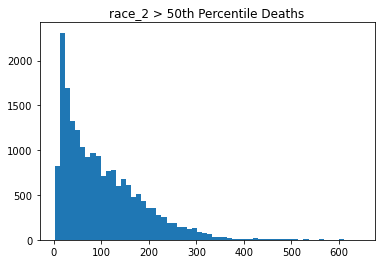

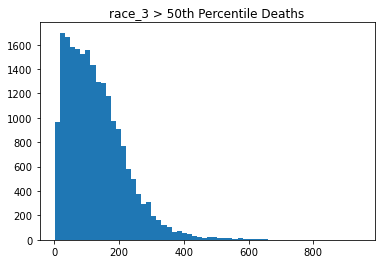

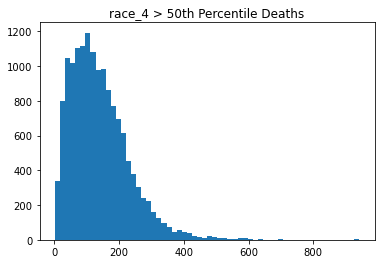

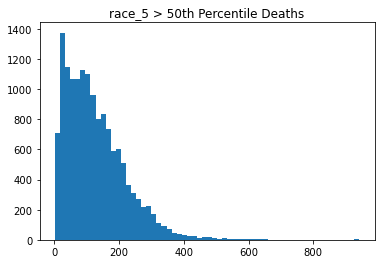

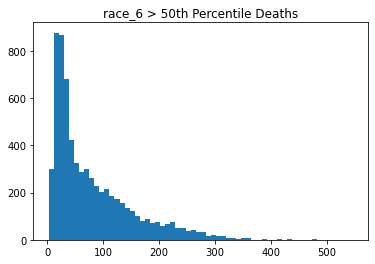

In [76]:
for i,df in enumerate(race_dfs):
    plt.hist(df.death,bins=60)
    plt.title(races[i] + ' > 50th Percentile'+ ' Deaths')
    plt.show()

In [24]:
# all categories of cvd: chf,  ischemic stroke,heart attack, heart disease
# source: https://www.heart.org/en/health-topics/consumer-healthcare/what-is-cardiovascular-disease
x_col = ['sex','mean_age','popdensity',#,'population', 
       'poverty',  'medianhousevalue', 
       'medhouseholdincome', 'pct_owner_occ',  'education',
       'smoke_rate', 'mean_bmi', 'race_1', 'race_2','race_3', 'race_4', 'race_5', 'race_6',
        'ICU_DAY', 'CCI_DAY', 'LOS',
       'Parkinson_pdx2dx_25', 'Alzheimer_pdx2dx_25', 'Dementia_pdx2dx_25',
       'COPD_pdx2dx_25', 'DM_pdx2dx_25',
       'Stroke_pdx2dx_25', 'CVD_pdx2dx_25', 'neo_140_149',
       'neo_150_159', 'neo_160_165', 'neo_170_176', 'neo_179_189',
       'neo_190_199', 'neo_200_209', 'neo_210_229', 'neo_230_234',
       'neo_235_238', 'neo_239', #'pm25','ozone','no2','tmmx','rmax']
        'pm25_summer_4y_avg', 'pm25_winter_4y_avg', # 'summer_pm25_above_12','winter_pm25_above_12',#
       'pm25_fall_4y_avg', 'pm25_spring_4y_avg', 'ozone_summer_4y_avg',
       'ozone_winter_4y_avg', 'ozone_fall_4y_avg', 'ozone_spring_4y_avg',
       'no2_summer_4y_avg', 'no2_winter_4y_avg', 'no2_fall_4y_avg',
       'no2_spring_4y_avg', 'summer_tmmx_4y_avg', 'summer_rmax_4y_avg',
       'winter_tmmx_4y_avg', 'winter_rmax_4y_avg']

y_col = 'deaths_next_year'
non_binary_preds = x_col

# split into train and test and standardize
X_train_standardized, y_train, X_test_standardized, y_test = split_and_standardize(df_train, x_col, y_col, non_binary_preds)

# split into train and test and not standardize - not needed for tree models
X_train2, y_train2, X_test2, y_test2 = split_and_standardize(df_train, x_col,y_col, non_binary_preds, s=False)

before: (61410, 53) (61410,)
after: (61410, 53) (61410,)
before: (61575, 53) (61575,)


### Gradient Boosting (Regressor)

https://blog.paperspace.com/implementing-gradient-boosting-regression-python/

https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_regression.html

In [96]:
# Create a based model
gbr1 = GradientBoostingRegressor()

param_grid_gbr = {
    'learning_rate': [0.01, 0.1],
    'max_depth': [4,6,8],
    'max_features': ['sqrt',],
    'n_estimators': [300, 400, 500],
    'subsample':[0.5,0.8,1]
}

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = gbr1, param_grid = param_grid_gbr, 
                          cv = 5, n_jobs = -1, verbose = 2)

# Fit the grid search to the data
grid_search.fit(X_train_standardized, y_train)
grid_search.best_params_

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:  7.5min finished


{'learning_rate': 0.1,
 'max_depth': 6,
 'max_features': 'sqrt',
 'n_estimators': 400,
 'subsample': 1}

In [97]:
# X_train_sub, y_train_sub, X_test_sub, y_test_sub
gbr_model = GradientBoostingRegressor(learning_rate=0.1,
                                      n_estimators=400,
                                      max_depth=6,
                                      subsample=1,
                                      max_features='sqrt')
gbr_model.fit(X_train_standardized, y_train)

GradientBoostingRegressor(max_depth=6, max_features='sqrt', n_estimators=400,
                          subsample=1)

In [98]:
print(gbr_model.score(X_train_standardized, y_train))
print(gbr_model.score(X_test_standardized, y_test))

0.9676255305793823
0.9219477260442658


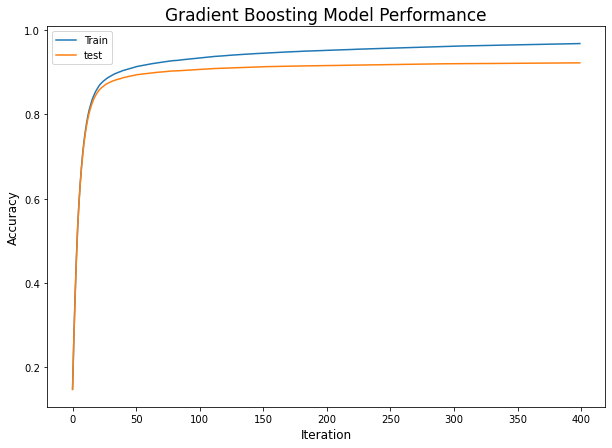

In [100]:
gbr_train_score = np.zeros((400,), dtype=np.float64)
for i, y_pred in enumerate(gbr_model.staged_predict(X_train_standardized)):
    gbr_train_score[i] = r2_score(y_train, y_pred)
    
gbr_test_score = np.zeros((400,), dtype=np.float64)
for i, y_pred in enumerate(gbr_model.staged_predict(X_test_standardized)):
    gbr_test_score[i] = r2_score(y_test, y_pred)

f, ax = plt.subplots(1, figsize=(10,7))
ax.plot(gbr_train_score,label='Train')
ax.plot(gbr_test_score,label='test')
ax.set_xlabel('Iteration', fontsize=12)
ax.set_ylabel('Accuracy', fontsize=12)
ax.set_title("Gradient Boosting Model Performance", fontsize=17)
plt.legend()
# f.savefig('gbr_results.png')
plt.show()

In [101]:
# gbr_train_pred_sub = gbr_model.predict(X_train_sub)
# gbr_test_pred_sub = gbr_model.predict(X_test_sub)
gbr_train_pred = gbr_model.predict(X_train_standardized)
gbr_test_pred = gbr_model.predict(X_test_standardized)

print(mean_squared_error(y_test, gbr_test_pred))
print(mean_squared_error(y_test, gbr_test_pred, squared=False))

# full_X_train_standardized_sub = standardize(x_col,df_train_sub[x_col])
# full_X_train_sub = full_X_train_standardized_sub[x_col]
# full_y_train_sub = full_X_train_standardized_sub['death_next_year']


614.8484519854746
24.796137844137636


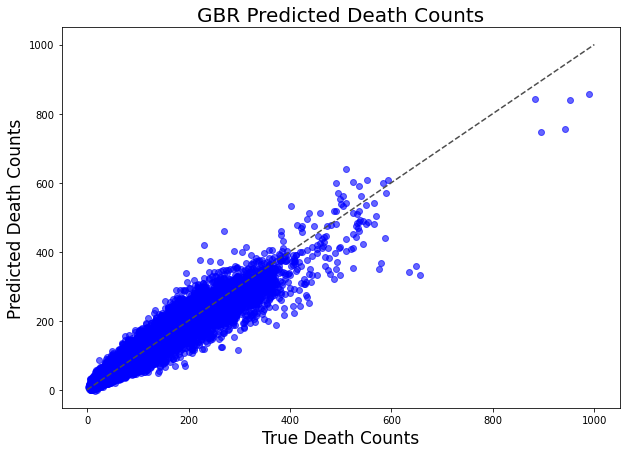

In [102]:
# note death is shifted, so must plot actual - year prior
plt.figure(figsize=(10,7))
plt.scatter(y_test,gbr_test_pred,color='blue',alpha=0.6) 
plt.plot([0, 1000], [0, 1000], ls="--", c=".3")
plt.title("GBR Predicted Death Counts", fontsize=20)
plt.ylabel("Predicted Death Counts", fontsize=17)
plt.xlabel("True Death Counts", fontsize=17)
# plt.savefig('gbr_pred.png')
plt.show()

In [103]:
final_X_test = standardize(x_col, df_test[x_col])
final_y_test = df_test['deaths_next_year']

final_gbr_test_pred = gbr_model.predict(final_X_test)
final_gbr_test_pred

array([ 23.09683194, 278.9448963 , 119.6344044 , ..., 156.15720914,
       314.28244922, 144.59747005])

In [113]:
df_test['GBR_death_pred'] = final_gbr_test_pred
df_test['change_in_deaths'] = ((df_test.GBR_death_pred - df_test.death) / df_test.death).values

In [1]:
ys = ['CVD','Stroke','Parkinson','Diabetic','MN: Unspecified',
      'Alzheimers','COPD','Dementia',
     'MN: Lymphatic', '# of ICU Days','Summer PM2.5',
      'MN: Genitourinary','popdensity','Winter Temp','Age']

gbr_feature_importance = gbr_model.feature_importances_
sorted_idx = np.argsort(gbr_feature_importance)

pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(30, 10))
plt.subplot(1, 2, 1)
plt.barh(pos[-15:], gbr_feature_importance[sorted_idx][-15:], align='center')
plt.yticks(pos[-15:], np.array(X_test_standardized.columns)[sorted_idx][-15:])
plt.title('GBR Feature Importance (Test Set)',fontsize=20)
plt.tight_layout()
# plt.savefig('gbr_feature_importance.png')
plt.show()

In [2]:
gbr_result = permutation_importance(gbr_model, X_test_standardized, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)

ys = ['CVD','Stroke','Diabetic','COPD','Summer PM2.5',
      'Winter Tmmx','Population Density',
      'Summer Tmmx','Parkinson','# of ICU Days',
      'Age', 'Spring Ozone','MN: Lymphatic', 
      'Native American','Mean BMI']

sorted_idx2 = gbr_result.importances_mean.argsort()
plt.subplots(1,figsize=(10,8))
plt.boxplot(gbr_result.importances[sorted_idx2].T[:,-15:],
            vert=False, labels=np.array(X_test_standardized.columns)[sorted_idx2][-15:]) #labels=ys[::-1]) # 
plt.title("GBR Permutation Importance (Test Set)",fontsize=20)
fig.tight_layout()
# plt.savefig('gbr_perm_importance.png')
plt.show()

### Histogram GBR

In [93]:
hgbr = HistGradientBoostingRegressor(loss='poisson', learning_rate=.1, 
                                    max_iter=400)
hgbr.fit(X_train_standardized, y_train)
print(hgbr.score(X_test_standardized, y_test))
print(hgbr.score(X_train_standardized, y_train))

0.9266589824739414
0.965967747934623


In [3]:
hgbr_result = permutation_importance(hgbr, X_test_standardized, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)

ys = ['CVD','Stroke','Diabetic','COPD','Summer PM2.5',
      'Winter Tmmx','Population Density',
      'Summer Tmmx','Parkinson','# of ICU Days',
      'Age', 'Spring Ozone','MN: Lymphatic', 
      'Native American','Mean BMI']

sorted_idx2 = hgbr_result.importances_mean.argsort()
plt.subplots(1,figsize=(10,8))
plt.boxplot(hgbr_result.importances[sorted_idx2].T[:,-15:],
            vert=False, labels=np.array(X_test_standardized.columns)[sorted_idx2][-15:]) #labels=ys[::-1]) # 
plt.title("HGBR Permutation Importance (Test Set)",fontsize=20)
fig.tight_layout()